In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import seaborn as sns
import statistics

In [27]:
results = pd.read_csv("test_results/pg_optimisations_retry_tpch_queries_test_results.csv") 
test_name = "postgres_optimisations"

results = results.rename(columns={"Average": "Mean"})

In [28]:
#print(len(results))
#results.head()

In [29]:
# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))

154


In [30]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

results['Median'] = results.apply(lambda row: statistics.median(sorted(row['Runs'])), axis = 1)

def ignore_first_mean(runs):
    return statistics.mean(runs[1:])

results['Mean'] = results.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
results["Query Type"] = results["Query Name"]

In [31]:
def process_optim_type(name):
    split_name = name.split(" ")
    if split_name[-1] == "Baseline":
        return "B"
    else:
        return str(split_name[-1]).strip()

results = results[results["Data Type"] != "SQL"]
results['Optimisation'] = results.apply(lambda row : process_optim_type(row['Query Name']), axis = 1)
#results

In [32]:
results = results.sort_values(by=['Query Number', 'Query Name'], ascending=[True, True])
#results.head(15)

In [33]:
#results
unique_query_numbers = list(results["Query Number"].unique())
q_scores_in_order = []
#unique_query_numbers
for q_num in unique_query_numbers:
    baseline_score = float(results[(results["Query Number"] == q_num) & (results["Optimisation"] == "B")]["Mean"])
    query_scores = results[(results["Query Number"] == q_num) & (results["Optimisation"] != "B")]
    
    optimisation_types = list(query_scores["Optimisation"].unique())
    for optim in optimisation_types:
        current_q_score = query_scores[query_scores["Optimisation"] == optim]
        q_scores_in_order.append(float((baseline_score - current_q_score["Mean"]) / baseline_score))
    q_scores_in_order.append(0)
    
    #print(baseline_score)

In [34]:

results['Optim_improve'] = pd.Series(q_scores_in_order, index=results.index)
#results.head(15)

In [35]:
optim_results = results \
    .groupby(by=["Optimisation"]) \
    .agg(
            avg_percent_improve=("Optim_improve", "mean"),
        )

optim_results['Percentage Improvement'] = optim_results['avg_percent_improve'].apply(lambda x: x*100)
optim_results = optim_results.reset_index()
optim_results = optim_results[optim_results["Optimisation"] != "B"]
optim_results

,Optimisation,avg_percent_improve,Percentage Improvement
0,1,-0.000194,-0.019370
1,1+2+3,0.005488,0.548769
2,2,0.001287,0.128695
3,2+3,0.003735,0.373460
4,3,0.000291,0.029060


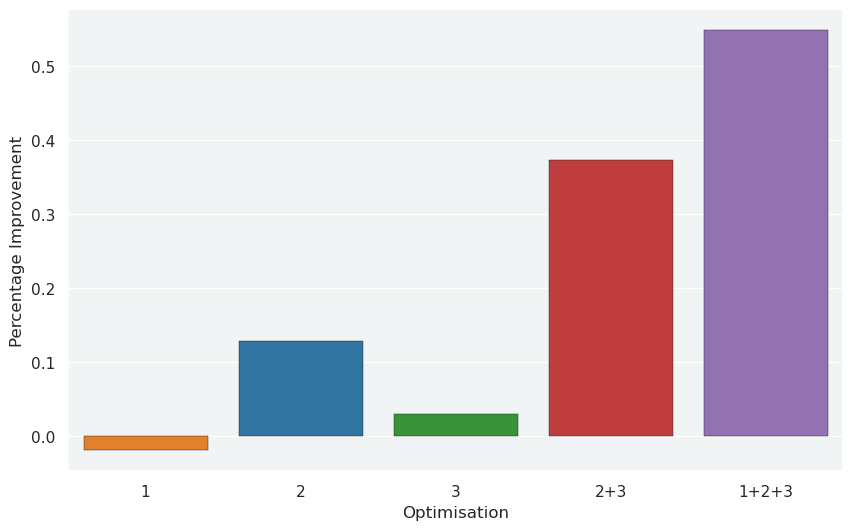

In [36]:
sns.set(rc={'figure.figsize':(10,6)})
background_color = '#f1f4f5'
sns.set(rc={'axes.facecolor':background_color})
plt.rcParams['patch.linewidth'] = 0.3
plt.rcParams['patch.edgecolor'] = 'k'

colors = ['tab:orange','tab:blue','tab:green', 'tab:red', 'tab:purple']
optim_order = ["1", "2", "3", "2+3", "1+2+3"]

ax = sns.barplot(data=optim_results, x='Optimisation', y='Percentage Improvement',
                 order=optim_order, palette=colors)

plt.savefig("analysis_results/" + str(test_name) + "_compare.pdf", bbox_inches="tight")
plt.show()